In [2]:
import sys
sys.path.append("../script")
from data_preparation import *
from utils import GridScore
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from statsmodels.discrete.discrete_model import Logit

# Import et préparation des données

In [3]:
train = pd.read_csv("../data/application_train_vf.csv")
test = pd.read_csv("../data/application_test_vf.csv")

In [ ]:
dataprep = DataPreparation(train, test, 0.3, plot = True)
train_prepared, test_prepared = dataprep.get_prepared_data()

In [4]:
#train_prepared.to_csv("../data/train_prepared.csv")
#test_prepared.to_csv("../data/test_prepared.csv")
train_prepared = pd.read_csv("../data/train_prepared.csv", index_col=[0])
test_prepared = pd.read_csv("../data/test_prepared.csv", index_col=[0])

In [5]:
df_train = train_prepared.copy()

In [6]:
df_train["TARGET"] = df_train["TARGET"].astype("int")

In [7]:
df_validation = df_train.iloc[280000:,:]
df_train = df_train.iloc[:280000,:]

In [8]:
for var in train_prepared[['FLAG_EMP_PHONE', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'LIVE_CITY_NOT_WORK_CITY']].columns : 
    df_validation[var] = df_validation[var].replace(1, 'un')
    df_validation[var] = df_validation[var].replace(0, 'zero')
    df_validation[var] = df_validation[var].replace(2, 'deux')
    df_validation[var] = df_validation[var].replace(3, 'trois')
    df_train[var] = df_train[var].replace(1, 'un')
    df_train[var] = df_train[var].replace(0, 'zero')
    df_train[var] = df_train[var].replace(2, 'deux')
    df_train[var] = df_train[var].replace(3, 'trois')
    train_prepared[var] = train_prepared[var].replace(1, 'un')
    train_prepared[var] = train_prepared[var].replace(0, 'zero')
    train_prepared[var] = train_prepared[var].replace(2, 'deux')
    train_prepared[var] = train_prepared[var].replace(3, 'trois')

# Modélisation

In [24]:
features = list(train_prepared.iloc[:,2:].columns)

In [25]:
reference_categories = {var : train_prepared[var].mode()[0] for var in features}

In [26]:
formula_parts = []
for var in features:
    if var in reference_categories:
        ref_category = reference_categories[var]
        formula_parts.append(f'C({var}, Treatment(reference="{ref_category}"))')

formula = 'TARGET ~ ' + ' + '.join(formula_parts)

In [27]:
model = Logit.from_formula(formula=formula, data=train_prepared)
logit_model = model.fit_regularized(maxiter = 500, method='l1')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.24642995848192825
            Iterations: 320
            Function evaluations: 321
            Gradient evaluations: 320


# Prédiction

In [28]:
pred = logit_model.predict(df_validation)

In [29]:
pred = pred.apply(lambda x : 0 if x < 0.5 else 1)

In [30]:
confusion_matrix(pred, df_validation["TARGET"])

array([[23769,  2307],
       [   19,    12]])

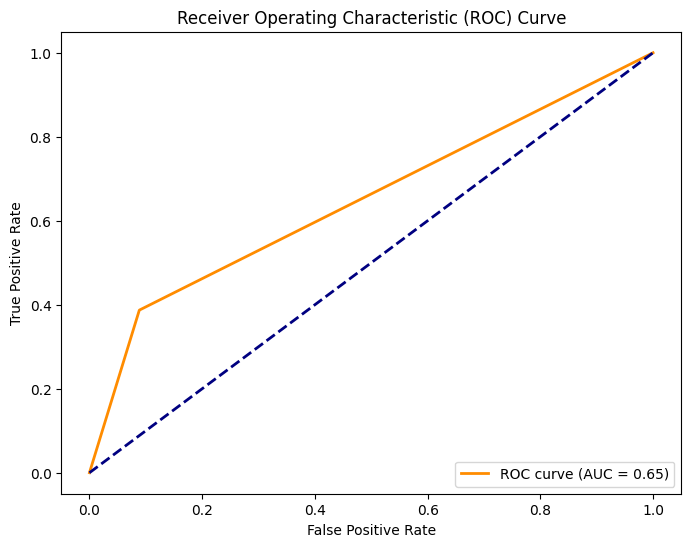

In [31]:
fpr, tpr, thresholds = roc_curve(pred, df_validation["TARGET"])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [32]:
roc_auc = auc(fpr, tpr)
gini_coefficient = 2 * roc_auc - 1
gini_coefficient

0.2986246158870598

# Grille de score

In [33]:
g = GridScore(train_prepared, logit_model).compute_grid_score()

In [34]:
g

,Variable,Modality,Coefficient,P-Value,Score,Contribution,Pcentage_Défaut,Pcentage_Classe
0,Intercept,-,-2.484269,0.0000,0.000000,0.0,0.00,0.00
1,DAYS_BIRTH_disc_int,[-18807;-13580]_ref,0.000000,0.0000,0.896057,2.0,2.68,36.16
2,DAYS_BIRTH_disc_int,[-13579;-7489],0.010000,0.5809,0.000000,2.0,3.37,33.31
3,DAYS_BIRTH_disc_int,[-25229;-18808],-0.230000,0.0000,21.505376,2.0,1.61,30.53
4,EXT_SOURCE_2_disc_int,[0.48;0.85]_ref,0.000000,0.0000,101.254480,10.0,3.44,65.31
...,...,...,...,...,...,...,...,...
68,FLAG_OWN_CAR,Y,-0.260000,0.0043,23.297491,3.0,2.34,34.02
69,FLAG_OWN_REALTY,Y_ref,0.000000,0.0000,0.000000,1.0,5.25,69.37
70,FLAG_OWN_REALTY,N,-0.060000,0.0001,5.376344,1.0,2.43,30.63
71,CODE_GENDER,F_ref,0.000000,0.0000,27.777778,3.0,4.37,65.87


## Calcul des scores individuels

In [35]:
score_dict = {}
for index, row in g.iterrows():
    var = row["Variable"]
    mod = row["Modality"].split("_ref")[0]
    score = row["Score"]
    
    if var not in score_dict:
        score_dict[var] = {}
    score_dict[var][mod] = score

In [36]:
def compute_score(row, features):
    score = 0
    for var in features :
        modality = row[var]
        score += score_dict[var][modality]
    return(score)

In [37]:
def compute_individual_score(df, features):
    df_score = df.copy()
    df_score["Score_ind"] = 0
    df_score["Score_ind"] = df_score.apply(lambda row : compute_score(row, features), axis = 1)
    return(df_score)

In [38]:
df2 = compute_individual_score(df_train, features)

(array([1.4100e+02, 1.9080e+03, 8.9680e+03, 2.6566e+04, 5.6447e+04,
        8.8152e+04, 7.2215e+04, 2.3056e+04, 2.4780e+03, 6.9000e+01]),
 array([282.25806452, 339.60573477, 396.95340502, 454.30107527,
        511.64874552, 568.99641577, 626.34408602, 683.69175627,
        741.03942652, 798.38709677, 855.73476703]),
 <BarContainer object of 10 artists>)

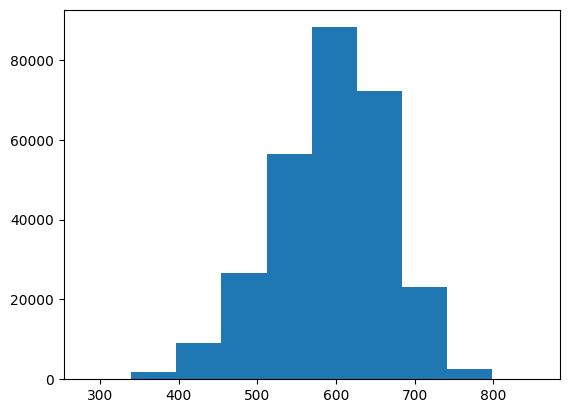

In [42]:
plt.hist(df2["Score_ind"])

In [44]:
df2.to_csv("../data/df_score.csv")